# Global Wheat Detection Competition

# Dataset and problem Overview

This competition is to discover the paths to identify wheat heads in a given image which is an object detection problem. 

The given dataset consists of 

- Train images (3422 images),
- Test images (10 images)

And notably the labels are:

- Train.csv (147793 rows and 5 columns)

Which infers that each image has multiple bounding boxes which detect the presence of wheat heads. And we are destined to find the same in the given test images. 

# Open and Load Images or dataset

Based on the observation, the csvs contain the labels, coordinates of bounding boxes, the photo ids. 
- Train test split is performed in the csvs and then their respective values can be mapped with the id in the csv file.
- Here I have used the open cv library to read the images and then albumentations library to transform the images.

**DatasetClass**
- Firstly the id and label are tapped from the csv file, then the id is sent along with the file format and is concatenated as string along with the data directory followed by file format like jpeg, png etc. 
- Then the cv2 command 'imread' is used to open the images and convert them to arrays. 

**Preprocess**
- Then the format is changed from bgr to rgb which is its default return type. Also in some grayscale images are used. 
- Then the respective labels are extracted and are attached before return.
- Then post opening the image it is sent to the transforms method and then brought back in. 
- The return value of the method contains image tensors and which can be later unpacked if needed.

**DataLoader**
- The processed data from the above step are passed through data loader to split into batches and shuffle the dataset to add some more randomness.
- Post the data loader the output was in the form of list of tensors of all batches input data, tensors of all labels.
Here the parameters used are batch size 1 for most models. Often batch sizes are kept low to reduce computational efficiency and speed.


# Experiments List:

**With Only prerequisite augmentations**

| EXP | MODEL | AUGMENTATIONS | SIZE | OTHER MODEL PARAMETERS | TEST mAP | PRIVATE | PUBLIC |
| -------- | ------- | ------- | ---- | ------- | ------- | ------- | ------- |
| 1 | Faster RCNN | ToTensor | 1024 | AdamW, 20 epochs | 0.6258 | 0.5492 | 0.6108 |
| 2 | Faster RCNN | ToTensor | 1024 | SGD, 10 epochs | 0.6164 | 0.5489 | 0.6107 |
| 3 | Faster RCNN | Sharpen, ToTensor | 1024 | SGD, 10 epochs | 0.6108 | 0.5456 | 0.6018 |
| 4 | Faster RCNN | ToTensor | 1024 | AdamW, 5 epochs | 0.6034 | 0.5267 | 0.6334 |
| 5 | Faster RCNN | ToTensor + lessloss | 1024 | SGD, 8 epochs | 0.5549 | 0.4954 | 0.6145 |

**With augmentations**

| EXP | MODEL | AUGMENTATIONS | SIZE | OTHER MODEL PARAMETERS | TEST mAP | PRIVATE | PUBLIC |
| -------- | ------- | ------- | ---- | ------- | ------- | ------- | ------- |
| 6 | Faster RCNN | Gray, ToTensor | 1024 | SGD, 10 epochs | 0.5884 | 0.5283 | 0.6157 |
| 7 | Faster RCNN | Brightness Contrast, ToTensor | 1024 | AdamW, 10 epochs | 0.5995 | 0.5267 | 0.6334 |
| 8 | Faster RCNN | Hue Saturation, ToTensor | 512 | SGD, 10 epochs | 0.5835 | 0.5236 | 0.6025 |
| 9 | Faster RCNN | Gray, ToTensor | 512 | AdamW, 10 epochs | 0.5661 | 0.5179 | 0.6305 |

**TTA, Pseudolabelling**

Pseudolabelling is the process of adding a proportion of test or prediction data with high confidence with the train data. And retrain the model to boost the performance. 

TTA(Test Time Augmentations) is used to incorporate the augmentations to test data while prediction one by one and the predicted values are averaged for final predictions.

| EXP | MODEL | AUGMENTATIONS | SIZE | OTHER MODEL PARAMETERS | TEST mAP | PRIVATE | PUBLIC |
| -------- | ------- | ------- | ---- | ------- | ------- | ------- | ------- |
| BEST | Faster RCNN | ToTensor, TTA | 1024 | AdamW, 10 epochs | 0.6405 | 0.5817 | 0.654 |
| 10 | Faster RCNN | ToTensor, Pseudolabelling (high mAP)| 1024 | AdamW, 10 epochs | 0.6949 | 0.4991 | 0.5756 |
| 11 | Faster RCNN | ToTensor, Pseudolabelling (less loss)| 1024 | AdamW, 8 epochs | 0.6949 | 0.4943 | 0.5533 |

Even tried with efficient det which was next preferred to fast rcnn but it didnot work out well with the scores

# CODE

In [1]:
import cv2
import os
import re
import timm
import torch
import numpy as np 
import pandas as pd
from torch import tensor
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms 
from matplotlib import pyplot as plt
from torchvision.ops.boxes import box_iou
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

If cuda is used the device is needed to be changed to the same else is kept at cpu

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

The csv containing the names or id of the images and the coordinates of the bounding boxes are read and the bounding boxes are made ready as seperate columns.

In [5]:
train_csv = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')
train_csv.drop(['width', 'height', 'source'], axis = 1, inplace = True)

In [6]:
train_path = '/kaggle/input/global-wheat-detection/train'
test_path = '/kaggle/input/global-wheat-detection/test'

In [7]:
train_csv

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"
...,...,...
147788,5e0747034,"[64.0, 619.0, 84.0, 95.0]"
147789,5e0747034,"[292.0, 549.0, 107.0, 82.0]"
147790,5e0747034,"[134.0, 228.0, 141.0, 71.0]"
147791,5e0747034,"[430.0, 13.0, 184.0, 79.0]"


In [9]:
train_csv.nunique()

image_id      3373
bbox        147761
dtype: int64

In [72]:
# train_csv_grouped = train_csv.groupby('image_id').agg(list)
# train_csv_grouped

Train test split upon unique values of image ids and then their respective bounding boxes are tapped in using the isin function and expand bbox user defined method.

In [73]:
train_rate = int(0.7*(train_csv['image_id'].nunique()))
test_rate = int(0.2*(train_csv['image_id'].nunique()))
val_rate = int(0.1*(train_csv['image_id'].nunique()))

In [74]:
train = train_csv['image_id'].unique()[:train_rate]
test = train_csv['image_id'].unique()[train_rate:(train_rate+test_rate)]
val = train_csv['image_id'].unique()[(train_rate+test_rate):]

In [75]:
train_df = train_csv[train_csv['image_id'].isin(train)]
test_df = train_csv[train_csv['image_id'].isin(test)]
val_df = train_csv[train_csv['image_id'].isin(val)]

In [76]:
train_df

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"
...,...,...
113240,8b7d61473,"[943.0, 101.0, 81.0, 54.0]"
113241,8b7d61473,"[151.0, 10.0, 117.0, 79.0]"
113242,8b7d61473,"[853.0, 3.0, 159.0, 48.0]"
113243,8b7d61473,"[942.0, 263.0, 82.0, 54.0]"


In [77]:
def get_bbox(df):
        df['x'] = -1
        df['y'] = -1
        df['w'] = -1
        df['h'] = -1

        def expand_bbox(x):
            r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
            if len(r) == 0:
                r = [-1, -1, -1, -1]
            return r
        df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x))) ##Lets convert the Box in 
        df['x'] = df['x'].astype(np.float)                                        #in our desired formate    
        df['y'] = df['y'].astype(np.float)
        df['w'] = df['w'].astype(np.float)
        df['h'] = df['h'].astype(np.float)
        df.drop(['bbox'],axis =1, inplace = True)
        return df

The images with no bounding boxes are made as -1

In [78]:
train_df = get_bbox(train_df)
test_df = get_bbox(test_df)
val_df = get_bbox(val_df)

In [79]:
train_df

,image_id,x,y,w,h
0,b6ab77fd7,834.0,222.0,56.0,36.0
1,b6ab77fd7,226.0,548.0,130.0,58.0
2,b6ab77fd7,377.0,504.0,74.0,160.0
3,b6ab77fd7,834.0,95.0,109.0,107.0
4,b6ab77fd7,26.0,144.0,124.0,117.0
...,...,...,...,...,...
113240,8b7d61473,943.0,101.0,81.0,54.0
113241,8b7d61473,151.0,10.0,117.0,79.0
113242,8b7d61473,853.0,3.0,159.0,48.0
113243,8b7d61473,942.0,263.0,82.0,54.0


# Dataset Class

In this class the data csv and the data directory are received as inputs and then the images from the directory are tapped in and their respective labels are clubbed after transformations and returned wherever called. 

Also the boxes are made from (x, y, w, h) pascal voc format to coco format(xmax, xmin, ymax, ymin). Then a new dictionary target is created with 5 parameters contained namely: crowd, labels, boxes, image ids and area. 

In [80]:
class ImageLoader(Dataset):
    def __init__(self,  data, data_dir, process = None):
        super().__init__()
        self.image_id = data['image_id'].unique()
        self.dataset = data
        self.data_dir = data_dir
        self.process = process
    
    def __len__(self):
        return self.image_id.shape[0]
    
    def __getitem__(self, item: int):
        img = self.image_id[item] 
        path = os.path.join(self.data_dir, img)
        image = cv2.imread(path + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         image = image.astype('uint8')
        
        records = self.dataset[self.dataset['image_id'] == img]
         # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
           
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([item])
        target['area'] = area
        target['iscrowd'] = iscrowd
                
        if self.process is not None:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
        
        return image, target, img  
    def train_transform(self,data):
        trans_tr = A.Compose([
                    A.Resize(height=1024, width=1024),
                    ToTensorV2(),
                    ])
#         trans_tr = A.Compose(
#                             [
#                             A.RandomSizedCrop(min_max_height=(800, 1024), height=1024, width=1024, p=0.5),
# #                             A.OneOf([
# # #                                     A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
# # #                                                          val_shift_limit=0.2, p=0.9),
# #                                     A.RandomBrightnessContrast(brightness_limit=0.2, 
# #                                                                contrast_limit=0.2, p=0.9),
# #                                 ],p=0.9),
#                             A.ToGray(p=0.01),
# #                                 A.HorizontalFlip(p=0.5),
# #                                 A.VerticalFlip(p=0.5),
# #                                 A.RandomRotate90(p=0.5),
#                             A.Transpose(p=0.5),
#                             A.JpegCompression(quality_lower=85, quality_upper=95, p=0.2),
#                             A.OneOf([
# #                             A.Blur(blur_limit=3, p=1.0),
# #                             A.MedianBlur(blur_limit=3, p=1.0)
#                             ],p=0.1),
#                                 A.Resize(height=1024, width=1024, p=1),
# #                                 A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
#                                 ToTensorV2(p=1.0),
#                             ], 
#                             p=1.0, 
#                         )
        return trans_tr(image = data)['image']
        
    def test_transform(self,data):
        trans_te = A.Compose([
                    A.Resize(height=1024, width=1024),
                    ToTensorV2(),
                    ])
        return trans_te(image = data)['image']

In [81]:
train_dataset = ImageLoader(train_df, train_path, 'train')
test_dataset = ImageLoader(test_df, train_path, 'train')
val_dataset = ImageLoader(val_df, train_path, 'train')

In [82]:
len(train_dataset)

2361

In [83]:
def collate_func(batch):
    return tuple(zip(*batch))

**Dataloader**

In [84]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn = collate_func, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn = collate_func, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn = collate_func, num_workers=2)

**View some transformed images with bounding boxes contained in them**

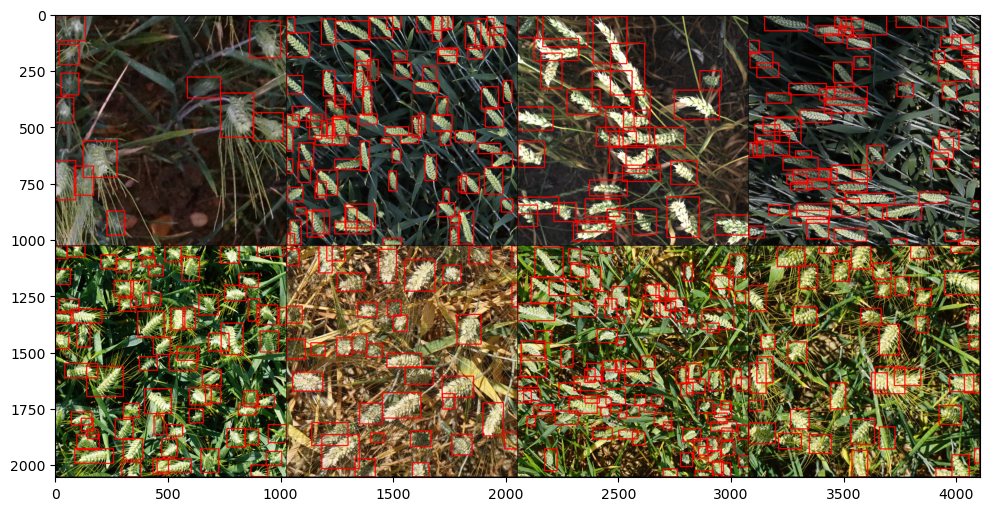

In [85]:
def show_transformed_images(dataset):
    loader = DataLoader(dataset, batch_size=8, shuffle = True, collate_fn = collate_func, num_workers=2)
    batch = next(iter(loader))
    images, target, labels = batch
    targets = [{k: v.to(device) for k, v in t.items()} for t in target]
    for i in range (8):
        boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
        sample = images[i].permute(1,2,0).cpu().numpy()
        for box in boxes:
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          (220, 0, 0), 3)
    grid = torchvision.utils.make_grid(list(images), nrow=4)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.tight_layout()
show_transformed_images(train_dataset)

Model creation is done using default pytorch by import statements rather than using a library.

In [86]:
# load a model; pre-trained on COCO
fst_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [87]:
num_classes = 2
# get number of input features for the classifier
in_features = fst_model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
fst_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [88]:
fst_model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Code for Mean Average Precision

In [89]:
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    best_match_iou = -np.inf
    best_match_idx = -1
    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form = form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    n = len(preds)
    tp = 0
    fp = 0
    
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1
        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)



def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), 
                                                     preds, 
                                                     threshold = threshold,
                                                     form = form,
                                                     ious = ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [90]:
optimizer = torch.optim.SGD(fst_model.parameters(), weight_decay=0.0005, lr=0.005)#omentum = 0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

Train Loop:
Inputs are passed and the model is trained having the model in train mode and the lossed are calculated by the sum of returned outputs (combined loss). Then the loss is backpropagated and optimizer is used to store and update gradients.

In [93]:
# Train and test

def train(num_epoch, model):
    itr = 0
    low_loss=10
    for epoch in tqdm(range(num_epoch)):
        losses = 0
        total = 1
        model.train()
        for images, targets, image_ids in train_loader:
            optimizer.zero_grad()
            train = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output_dict = model(train, targets)
            loss = sum(loss for loss in output_dict.values())
            loss_value = loss.item()
            losses += loss
            loss_in_batch = losses/total
            
#             optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if itr % 100 == 0:
                print(f"Iteration #{itr} loss: {loss_in_batch}")
            itr += 1
            total+=1
        losses = losses/len(train_loader)
#         metric = calculate_map()
        if lr_scheduler is not None:
            lr_scheduler.step()
        print(f'''Epoch {epoch+1}: Train     : The loss is {losses}''')
        
        if losses < low_loss:
            low_loss = losses
            torch.save(model.state_dict(),f'lessloss{epoch+1}model.pt')
        test(model, epoch)
        evaluation(model)
        print('-'*110)
        torch.save(model.state_dict(),f'Epoch{epoch+1}model.pt')

Test and eval is done with the model in evaluation mode. Here no gradients are passed between. Also the predictions are tapped and the metric is called to evaluate the model performance.

In [94]:
def evaluation(model):
    model.eval()
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    res_scores = []
    with torch.inference_mode():
        for x, y, z in val_loader:
            train = list(image.to(device) for image in x)
            targets = [{k: v.to(device) for k, v in t.items()} for t in y]
            outputs = model(train)
            for i in range (len(targets)):
                gt_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].data.cpu().numpy()
                pred_scores = outputs[i]['scores'].data.cpu().numpy()
                preds_sorted_idx = np.argsort(pred_scores)[::-1]
                preds_sorted = pred_boxes[preds_sorted_idx]
                metric = calculate_image_precision(gt_boxes, preds_sorted, iou_thresholds, form = 'pascal_voc')
                res_scores.append(metric)
        mAP = np.mean(res_scores)
        print(f'\t Validation :mAP : {mAP}')

In [95]:
def test(model, epoch):
    model.eval()
    high_mAP = 0
    test_loss = 0
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
    res_scores = []
    with torch.inference_mode():
        for x, y, z in test_loader:
            train = list(image.to(device) for image in x)
            targets = [{k: v.to(device) for k, v in t.items()} for t in y]
            outputs = model(train)
            for i in range (len(targets)):
                act = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].data.cpu().numpy()
                pred_scores = outputs[i]['scores'].data.cpu().numpy()
                preds_sorted_idx = np.argsort(pred_scores)[::-1]
                preds = pred_boxes[preds_sorted_idx]
                metric = calculate_image_precision(act, preds, iou_thresholds, form = 'pascal_voc')
                res_scores.append(metric)
        mAP = np.mean(res_scores)
        if high_mAP < mAP:
            high_mAP = mAP
            torch.save(model.state_dict(),f'highmAP{epoch+1}model.pt')
        print(f'\t Test      : mAP : {mAP}')

In [96]:
%%time
torch.manual_seed(42) 
torch.cuda.manual_seed(42)
train(5,fst_model) 

  0%|          | 0/5 [00:00<?, ?it/s]

Iteration #0 loss: 5.767934799194336
Iteration #100 loss: 1.1128214597702026
Iteration #200 loss: 1.0199297666549683
Epoch 1: Train     : The loss is 0.9391275644302368
	 Test      : mAP : 0.2736072250624818
	 Validation :mAP : 0.21161225654496332
--------------------------------------------------------------------------------------------------------------


 20%|██        | 1/5 [06:43<26:53, 403.31s/it]

Iteration #300 loss: 1.0084314346313477
Iteration #400 loss: 0.9119606018066406
Iteration #500 loss: 0.8782898783683777
Epoch 2: Train     : The loss is 0.8256041407585144
	 Test      : mAP : 0.42667789930688493
	 Validation :mAP : 0.30251706028377084
--------------------------------------------------------------------------------------------------------------


 40%|████      | 2/5 [13:02<19:28, 389.34s/it]

Iteration #600 loss: 0.9081919193267822
Iteration #700 loss: 0.8807106614112854
Iteration #800 loss: 0.8384580612182617
Epoch 3: Train     : The loss is 0.7922868132591248
	 Test      : mAP : 0.4699012043128458
	 Validation :mAP : 0.3356403259475799
--------------------------------------------------------------------------------------------------------------


 60%|██████    | 3/5 [19:17<12:44, 382.48s/it]

Iteration #900 loss: 0.8908421993255615
Iteration #1000 loss: 0.8703185319900513
Iteration #1100 loss: 0.8268610835075378
Epoch 4: Train     : The loss is 0.7855830192565918
	 Test      : mAP : 0.445338607177729
	 Validation :mAP : 0.32403315832166946
--------------------------------------------------------------------------------------------------------------


 80%|████████  | 4/5 [25:35<06:20, 380.79s/it]

Iteration #1200 loss: 0.8538884520530701
Iteration #1300 loss: 0.8579349517822266
Iteration #1400 loss: 0.8171744346618652
Epoch 5: Train     : The loss is 0.7776128053665161
	 Test      : mAP : 0.45190235128145717
	 Validation :mAP : 0.3308732634136024
--------------------------------------------------------------------------------------------------------------


100%|██████████| 5/5 [31:52<00:00, 382.54s/it]

CPU times: user 28min 50s, sys: 1min 15s, total: 30min 6s
Wall time: 31min 52s


# Conclusion:

Upon choosing the best mAP and submission of models the best variant turned out to be the one mentioned below:

    MODEL : Faster RCNN
    Learning rate: 0.0001
    Optimizer: AdamW
    Local mAP : 0.6627
    Public Score : 0.654
    Private Score: 0.5817

# Future Scope:

- Trials upon pseudolabelling multiple times(recurrent).
- Add on some more data
- Trials with some more augmentations can hopefully improve the mdoel.
- Have to try with some more models.